# Exploring mode equivalence

I've spent the last few experiments looking at the result of one single (particularly optimal-looking) training run. I'm going to see if I can find some more and see whether they're equivalent. This might help lead me to generate some kind of probe for their existence.

In [1]:
import torch
from torch import nn
from torch.optim import Adam
from matplotlib import pyplot as plt
from matplotlib import cm
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np

from physics_mi.utils import set_all_seeds

In [2]:
seed = np.random.randint(1, 2**32 - 1)  # now starting to search through the seeds again
set_all_seeds(seed)
print(seed)

2924058170


## Model

Keeping this extremely simple

In [3]:
class LinearLayer(nn.Module):
    def __init__(self, in_feats, out_feats, use_act=True, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.linear = nn.Linear(in_feats, out_feats)
        if use_act:
            self.act = nn.ReLU()
        self.use_act = use_act

    def forward(self, x):
        x = self.linear(x)
        if self.use_act:
            x = self.act(x)
        return x


class Net(nn.Module):
    def __init__(self, use_act=True, dim=32, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.layers = nn.Sequential(LinearLayer(2, dim, use_act=use_act), LinearLayer(dim, 1, use_act=False))

    def forward(self, x):
        return self.layers(x)

## Data

Going to sample $x_1$ (mass) and $x_2$ (acceleration) such that their product is uniformly distributed.

In [4]:
eps = 0.5

Y = torch.rand(10000)
X = torch.empty(10000, 2)
X[:, 0] = Y / (torch.rand(10000) * (1 - eps) + eps)
X[:, 1] = Y / X[:, 0]

# need to randomly swap x1 and x2 so that they're identically distributed - can do this because their product is commutative
mask = torch.rand(10000) < 0.5
swap_vals = X[:, 0][mask]
X[:, 0][mask] = X[:, 1][mask]
X[:, 1][mask] = swap_vals

assert torch.allclose(X[:, 0] * X[:, 1], Y)

Y = Y[:, None]
X.shape, Y.shape

(torch.Size([10000, 2]), torch.Size([10000, 1]))

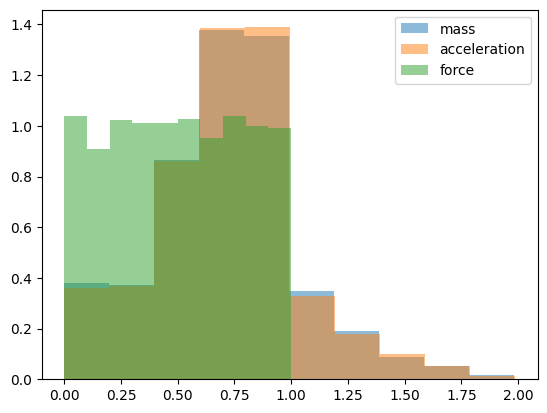

In [5]:
fig, ax = plt.subplots()

ax.hist(X[:, 0], alpha=0.5, density=True, label="mass")
ax.hist(X[:, 1], alpha=0.5, density=True, label="acceleration")
ax.hist(Y[:, 0], alpha=0.5, density=True, label="force")
ax.legend()

In [6]:
s_inds = np.random.permutation(range(X.shape[0]))  # shuffled indices

X_train = X[s_inds[:8000]]
Y_train = Y[s_inds[:8000]]
X_valid = X[s_inds[8000:]]
Y_valid = Y[s_inds[8000:]]

X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape

(torch.Size([8000, 2]),
 torch.Size([8000, 1]),
 torch.Size([2000, 2]),
 torch.Size([2000, 1]))

## Training

I'll just do full gradient descent to keep things simple.

In [7]:
N = 4000  # number of epochs

model = Net(use_act=True, dim=2)
loss_func = nn.MSELoss()
optimiser = Adam(model.parameters(), lr=1e-3)
log = []

for i in tqdm(range(N)):
    log_sample = {}

    # Training update
    model.train()
    model.zero_grad()
    Y_hat = model(X_train)
    loss = loss_func(Y_hat, Y_train)
    log_sample["train_loss"] = float(loss.detach())
    loss.backward()
    optimiser.step()

    # Validation set
    model.eval()
    Y_hat = model(X_valid)
    loss = loss_func(Y_hat, Y_valid)
    log_sample["valid_loss"] = float(loss.detach())

    log.append(log_sample)

df = pd.DataFrame(log)

  0%|          | 0/4000 [00:00<?, ?it/s]

## Results

In [8]:
def plot_loss(train_loss, valid_loss):
    _, ax = plt.subplots()

    ax.plot(train_loss, label="train")
    ax.plot(valid_loss, label="valid")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.legend()


def get_preds(model):
    model.eval()

    with torch.inference_mode():
        out = model(X_valid)

    y_preds = out.flatten().numpy()
    y_targs = Y_valid.flatten().numpy()

    return y_preds, y_targs


def get_valid_loss(model, loss_func):
    model.eval()

    with torch.inference_mode():
        out = model(X_valid)

    return loss_func(out, Y_valid)


def plot_results(y_preds, y_targs):
    _, ax = plt.subplots()

    ax.scatter(y_preds, y_targs, s=4, label="predictions")
    ax.plot(y_targs, y_targs, color="salmon", ls="--", lw=0.5, label="perfect accuracy")
    ax.set(xlabel="y_preds", ylabel="y_targs")
    ax.legend()

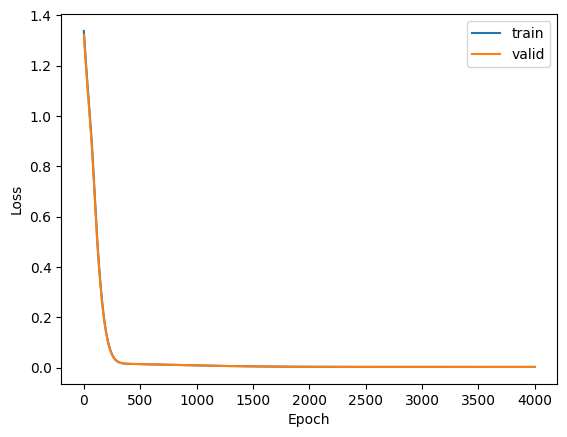

In [9]:
plot_loss(df["train_loss"], df["valid_loss"])

In [10]:
y_preds, y_targs = get_preds(model)

In [11]:
get_valid_loss(model, loss_func)

tensor(0.0034)

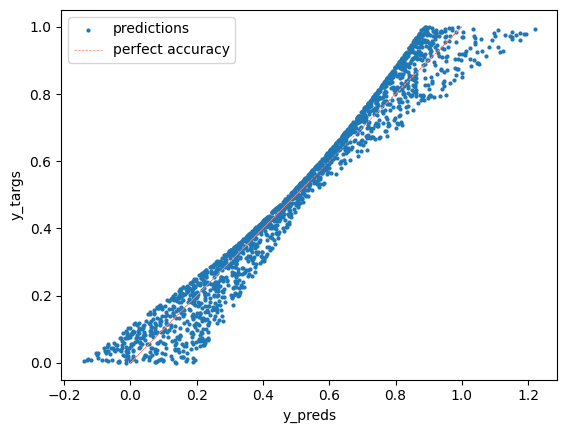

In [12]:
plot_results(y_preds, y_targs)

## Introspection

In [13]:
model

Net(
  (layers): Sequential(
    (0): LinearLayer(
      (linear): Linear(in_features=2, out_features=2, bias=True)
      (act): ReLU()
    )
    (1): LinearLayer(
      (linear): Linear(in_features=2, out_features=1, bias=True)
    )
  )
)

In [14]:
for name, param in model.named_parameters():
    print(name, "\n", param.data, "\n")

layers.0.linear.weight 
 tensor([[0.0384, 0.3001],
        [0.5565, 0.6368]]) 

layers.0.linear.bias 
 tensor([-0.0018, -0.3243]) 

layers.1.linear.weight 
 tensor([[-0.3914,  1.2702]]) 

layers.1.linear.bias 
 tensor([-0.0869]) 



### Inspect intermediate values

Going to go operation by operation to see if I can see what's going on.

input ($\rightarrow$ prebias_preacts $\rightarrow$ preacts $\rightarrow$ acts) ($\rightarrow$ prebias $\rightarrow$ output)

(with the layers grouped in brackets)

In [15]:
SD = model.state_dict()

In [16]:
from collections import OrderedDict


def model_breakdown(x1, x2, print_steps=True, return_steps=False):
    x1, x2 = float(x1), float(x2)

    x = torch.tensor([[x1, x2]]).T
    prebias_preacts = torch.matmul(SD["layers.0.linear.weight"], x)
    preacts = prebias_preacts[:, 0] + SD["layers.0.linear.bias"]
    acts = torch.nn.functional.relu(preacts)
    prebias = torch.matmul(SD["layers.1.linear.weight"], acts)
    output = prebias + SD["layers.1.linear.bias"]

    if print_steps:
        print("Input:", "\n", x, "\n")

        print("================ Layer 0 ================", "\n")
        print("Weight:", "\n", SD["layers.0.linear.weight"], "\n")
        print("Result:", "\n", prebias_preacts, "\n")
        print("Bias:", "\n", SD["layers.0.linear.bias"], "\n")
        print("Result:", "\n", preacts, "\n")
        print("Activations:", "\n", acts, "\n")

        print("================ Layer 1 ================", "\n")
        print("Weight:", "\n", SD["layers.1.linear.weight"], "\n")
        print("Result:", "\n", prebias, "\n")
        print("Bias:", "\n", SD["layers.1.linear.bias"], "\n")
        print("Output:", "\n", output, "\n")

        print(f"y_true = {x1*x2:.3f}")

    if return_steps:
        return prebias_preacts, preacts, acts, prebias, output


def plot_model_breakdown(
    x1,
    x2,
    ax=None,
    legend=True,
    color=None,
    product_color=False,
    point_selector={
        "input": True,
        "prebias_preacts": False,
        "preacts": False,
        "acts": False,
        "prebias": False,
        "output": True,
    },
):
    if not ax:
        fig = plt.figure()
        ax = plt.axes()

    input = (x1, x2)

    if not color and product_color:
        val = x1 * x2
        cmap = cm.plasma
        val = val**0.5  # looks better on the unit square with some scaling
        color = cmap(val)

    prebias_preacts, preacts, acts, prebias, output = model_breakdown(*input, print_steps=False, return_steps=True)

    x = OrderedDict()
    x["input"] = input
    x["prebias_preacts"] = prebias_preacts.flatten().tolist()
    x["preacts"] = preacts.flatten().tolist()
    x["acts"] = acts.flatten().tolist()
    x["prebias"] = [float(prebias), 0]
    x["output"] = [float(output), 0]

    markers = {}
    markers["input"] = "v"
    markers["prebias_preacts"] = "o"
    markers["preacts"] = "o"
    markers["acts"] = "o"
    markers["prebias"] = "o"
    markers["output"] = "x"

    for point_name, point in x.items():
        if point_selector[point_name]:
            ax.scatter(*point, alpha=1.0, label=point_name, color=color, marker=markers[point_name])

    x_arr = np.array(list(x.values()))

    ax.plot(*x_arr.T, lw=0.5, color=color)
    ax.set(xlabel="component 0", ylabel="component 1")
    if legend:
        ax.legend()


def get_colors(N):
    cmap = plt.get_cmap("turbo", N)
    colors = []
    for i in range(cmap.N):
        colors.append(cmap(i))
    return colors

In [17]:
model_breakdown(0.75, 1.0)

Input: 
 tensor([[0.7500],
        [1.0000]]) 

================ Layer 0 ================ 

Weight: 
 tensor([[0.0384, 0.3001],
        [0.5565, 0.6368]]) 

Result: 
 tensor([[0.3289],
        [1.0542]]) 

Bias: 
 tensor([-0.0018, -0.3243]) 

Result: 
 tensor([0.3272, 0.7299]) 

Activations: 
 tensor([0.3272, 0.7299]) 

================ Layer 1 ================ 

Weight: 
 tensor([[-0.3914,  1.2702]]) 

Result: 
 tensor([0.7990]) 

Bias: 
 tensor([-0.0869]) 

Output: 
 tensor([0.7122]) 

y_true = 0.750


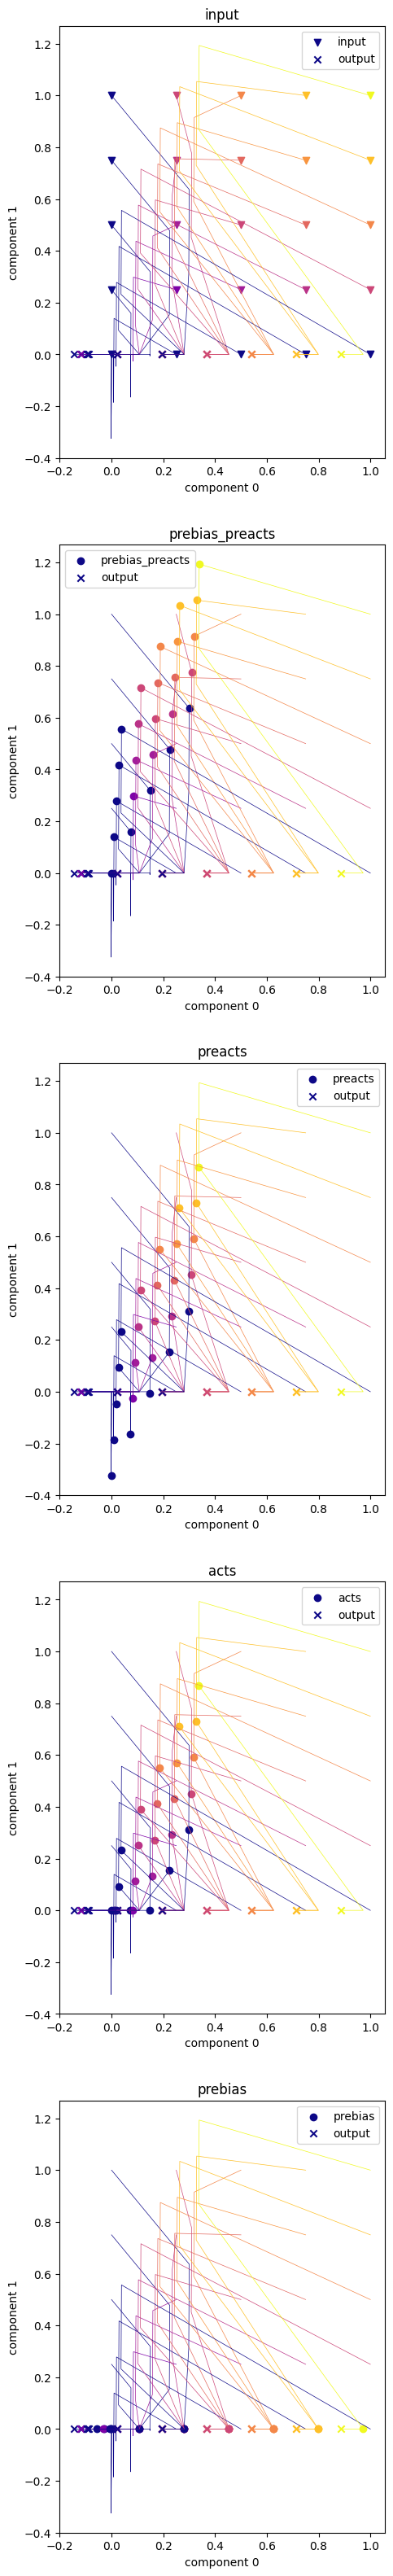

In [18]:
fig, axes = plt.subplots(5, 1, figsize=(10, 40))

N = 5
pairs = np.concatenate(np.stack(np.meshgrid(np.linspace(0, 1, N), np.linspace(0, 1, N))).T)

# cols = get_colors(len(pairs))

subsets = [
    {
        "input": True,
        "prebias_preacts": False,
        "preacts": False,
        "acts": False,
        "prebias": False,
        "output": True,
    },
    {
        "input": False,
        "prebias_preacts": True,
        "preacts": False,
        "acts": False,
        "prebias": False,
        "output": True,
    },
    {
        "input": False,
        "prebias_preacts": False,
        "preacts": True,
        "acts": False,
        "prebias": False,
        "output": True,
    },
    {
        "input": False,
        "prebias_preacts": False,
        "preacts": False,
        "acts": True,
        "prebias": False,
        "output": True,
    },
    {
        "input": False,
        "prebias_preacts": False,
        "preacts": False,
        "acts": False,
        "prebias": True,
        "output": True,
    },
]

titles = ["input", "prebias_preacts", "preacts", "acts", "prebias"]

for ax, subset, title in zip(axes.flatten(), subsets, titles):
    plot_model_breakdown(*pairs[0], ax, product_color=True, point_selector=subset)
    for pair in pairs[1:]:
        plot_model_breakdown(*pair, ax, legend=False, product_color=True, point_selector=subset)
    ax.set_title(title)
    ax.set_aspect("equal")

Things I'm seeing:
1. More mode 2 examples where the model hasn't learnt that it can do the projection in two steps (ReLU + final linear layer) but instead just uses the ReLU (and the weights of the final linear layer become a little redundant).
1. Rotated mode 3 examples which use the "x" axis to do the projection.
1. With mode 2, it seems the optimal first linear transform results in completely aligned diagonals (the rough iso-diagonals that I pointed out in experiment 3), this is because the full ReLU projection leaves no room to further separate according to the variation _within_ the diagonal (see seed `3693656414` for an example)
1. I've found a further mode that makes sense, perhaps I'd call it mode 2.5, where instead of relying on the _ReLU_ to do the projection, the network instead uses the final linear layer. Presumably this is more expressive 🤔 (see seed `666070537`)

I think I've done enough now to convince myself that I've found all the modes at least with my current training setup.

In [19]:
# torch.save(model.state_dict(), 'models/e-9.pth')